#**Product Recommendation System**

##**Project Overview**
Dalam proyek ini, kami membangun sistem rekomendasi produk, dari situs web e-commerce, menggunakan pendekatan *Content-Based Filtering* dan *Collaborative Filtering* untuk membantu pengguna menemukan produk yang relevan berdasarkan preferensi/ riwayat pembelian dan perilaku penelusuran mereka

1. Content-Based Filtering yaitu menganalisis karakteristik produk untuk memberikan rekomendasi berdasarkan kesamaan dengan produk lain.
2. Collaborative Filtering yaitu menggunakan data interaksi pengguna untuk merekomendasikan produk yang diminati oleh pengguna serupa.

##**Business Understanding**

**Problem Statements**<br>
Pengguna sering menghadapi tantangan dalam memilih produk yang tepat karena banyaknya pilihan yang ada, yang sesuai untuk kondisi mereka. Oleh karena itu, penting untuk menciptakan sistem rekomendasi yang dapat membantu pengguna dalam memilih produk yang tepat dan relevan, dimana pengguna puas, sekaligus dapat meningkatkan penjualan & profit perusahaan.

**Goals**<br>
1. Mengembangkan sistem rekomendasi produk yang dapat memberikan saran produk yang lebih tepat berdasarkan data produk, konsumen dan pengalaman pengguna lain.
2. Membantu konsumen dalam memilih produk yang lebih sesuai dan memuaskan, sekaligus meningkatkan penjualan produk dari perusahaan, dengan memanfaatkan pendekatan algoritma Content-Based Filtering dan Collaborative Filtering.

**Solution Approach**<br>
* Content-Based Filtering digunakan untuk memberikan rekomendasi item yang serupa dengan apa yang pernah dibeli atau dilihat pengguna sebelumnya berdasarkan detail karakteristik/ atribut produk, seperti kategori, merek, harga dan diskripsi produk.
* Collaborative Filtering digunakan untuk memberikan rekomendasi dari data perilaku konsumen untuk mengidentifikasi pola berdasarkan rating dan preferensi pengguna lain yang memiliki riwayat pembelian sebelumnya.

##**Data Understanding**

**Exploratory Data Analysis (EDA) & Data Visualization**<br>

Sebelum membangun model, perlu dilakukan eksplorasi data untuk memahami struktur dataset dan kualitasnya.

Dalam proyek ini, kami menggunakan dataset yang berasal dari database "Bigbasket", supermarket grosir online terbesar di India, yang dapat di akses pada link [ini](https://www.kaggle.com/datasets/amrit0611/big-basket-product-analysis/data).

In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.metrics import mean_squared_error, precision_score
from sklearn.neighbors import NearestNeighbors

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/BigBasketProducts.csv')

  **1. Output 5 baris pertama dataset "BigBasketProducts.csv" dengan fungsi ```head```**

In [4]:
df.head()

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


**2. Struktur dataset**<br>
Dataset terdiri dari 10 kolom dengan 27555 baris. Mayoritas kolom bertipe ```object``` dan sebagian bertipe ```float64``` kecuali kolom *index* bertipe ```int64```. Berikut detail variabel fitur dataset ini:<br>

        index: Nama obat yang digunakan.
        product: Nama produk (dapat digunakan untuk deskripsi dalam Content-Based Filtering).
        category: Kategori utama produk.
        sub_category: Sub-kategori produk.
        brand: Merek produk.
        sale_price: Harga jual produk diplatform e-commerce.
        market_price: Harga produk dipasaran.
        type: Tipe produk (lebih spesifik dibanding kategori/sub-kategori).
        rating: Rating pengguna (berguna untuk evaluasi Collaborative Filtering).
        description: Deskripsi produk (fitur utama untuk Content-Based Filtering).

In [5]:
df.shape

(27555, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27555 entries, 0 to 27554
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         27555 non-null  int64  
 1   product       27554 non-null  object 
 2   category      27555 non-null  object 
 3   sub_category  27555 non-null  object 
 4   brand         27554 non-null  object 
 5   sale_price    27555 non-null  float64
 6   market_price  27555 non-null  float64
 7   type          27555 non-null  object 
 8   rating        18929 non-null  float64
 9   description   27440 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 2.1+ MB


**3. Statistik Deskriptif (untuk kolom Age)**:<br>
Kolom yang dapat diproses menggunakan fungsi ```describe()``` adalah kolom  bertipe numeric, yaitu data ```int64``` & ```float64```. Berdasarkan output dibawah, rentang harga jual di platform, dari terendah (```min```) adalah 2,45 Rupee hingga harga tertinggi (```max```) 12.500 Rupee, sedangkan rata-rata rating (```mean```) adalah 3,94.

In [7]:
df.describe()

,index,sale_price,market_price,rating
count,27555.00000,27555.000000,27555.000000,18929.000000
mean,13778.00000,322.514808,382.056664,3.943410
std,7954.58767,486.263116,581.730717,0.739063
min,1.00000,2.450000,3.000000,1.000000
25%,6889.50000,95.000000,100.000000,3.700000
50%,13778.00000,190.000000,220.000000,4.100000
75%,20666.50000,359.000000,425.000000,4.300000
max,27555.00000,12500.000000,12500.000000,5.000000


**4. Data Kosong (Missing Values)**<br>
Kolom *rating* memiliki nilai yang hilang yang paling tinggi (8626 nilai kosong, dari total 27555 entri), yang bisa jadi mempengaruhi analisis lebih lanjut.

In [8]:
df.isnull().sum()

,0
index,0
product,1
category,0
sub_category,0
brand,1
sale_price,0
market_price,0
type,0
rating,8626
description,115


**5. Jumlah nilai unik setiap kolom**

In [9]:
for column in df.columns:
    print(f'{column} mempunyai {df[column].nunique()} nilai yang unik')

index mempunyai 27555 nilai yang unik
product mempunyai 23540 nilai yang unik
category mempunyai 11 nilai yang unik
sub_category mempunyai 90 nilai yang unik
brand mempunyai 2313 nilai yang unik
sale_price mempunyai 3256 nilai yang unik
market_price mempunyai 1348 nilai yang unik
type mempunyai 426 nilai yang unik
rating mempunyai 40 nilai yang unik
description mempunyai 21944 nilai yang unik


**6. Visualisasi jumlah item disetiap kategori**

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Beauty & Hygiene'),
  Text(1, 0, 'Kitchen, Garden & Pets'),
  Text(2, 0, 'Cleaning & Household'),
  Text(3, 0, 'Gourmet & World Food'),
  Text(4, 0, 'Foodgrains, Oil & Masala'),
  Text(5, 0, 'Snacks & Branded Foods'),
  Text(6, 0, 'Beverages'),
  Text(7, 0, 'Bakery, Cakes & Dairy'),
  Text(8, 0, 'Baby Care'),
  Text(9, 0, 'Fruits & Vegetables'),
  Text(10, 0, 'Eggs, Meat & Fish')])

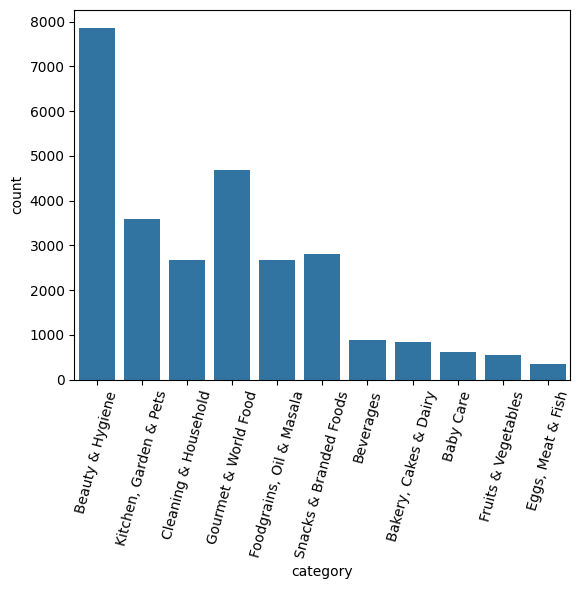

In [10]:
sns.countplot(data=df, x='category')
plt.xticks(rotation=75)

**7. Visualisasi 10 produk terlaris**

In [11]:
top_10 = pd.DataFrame(df[['product', 'category']].value_counts().head(10)).reset_index()
top_10.columns = ['produk', 'kategori', 'jumlah']
top_10

,produk,kategori,jumlah
0,Turmeric Powder/Arisina Pudi,"Foodgrains, Oil & Masala",26
1,Extra Virgin Olive Oil,Gourmet & World Food,14
2,Cow Ghee/Tuppa,"Foodgrains, Oil & Masala",14
3,Soft Drink,Beverages,12
4,Colorsilk Hair Colour With Keratin,Beauty & Hygiene,12
5,Coriander Powder,"Foodgrains, Oil & Masala",11
6,Ghee/Tuppa,"Foodgrains, Oil & Masala",11
7,Powder - Coriander,"Foodgrains, Oil & Masala",11
8,Olive Oil - Extra Virgin,Gourmet & World Food,11
9,Hand Sanitizer,Beauty & Hygiene,10


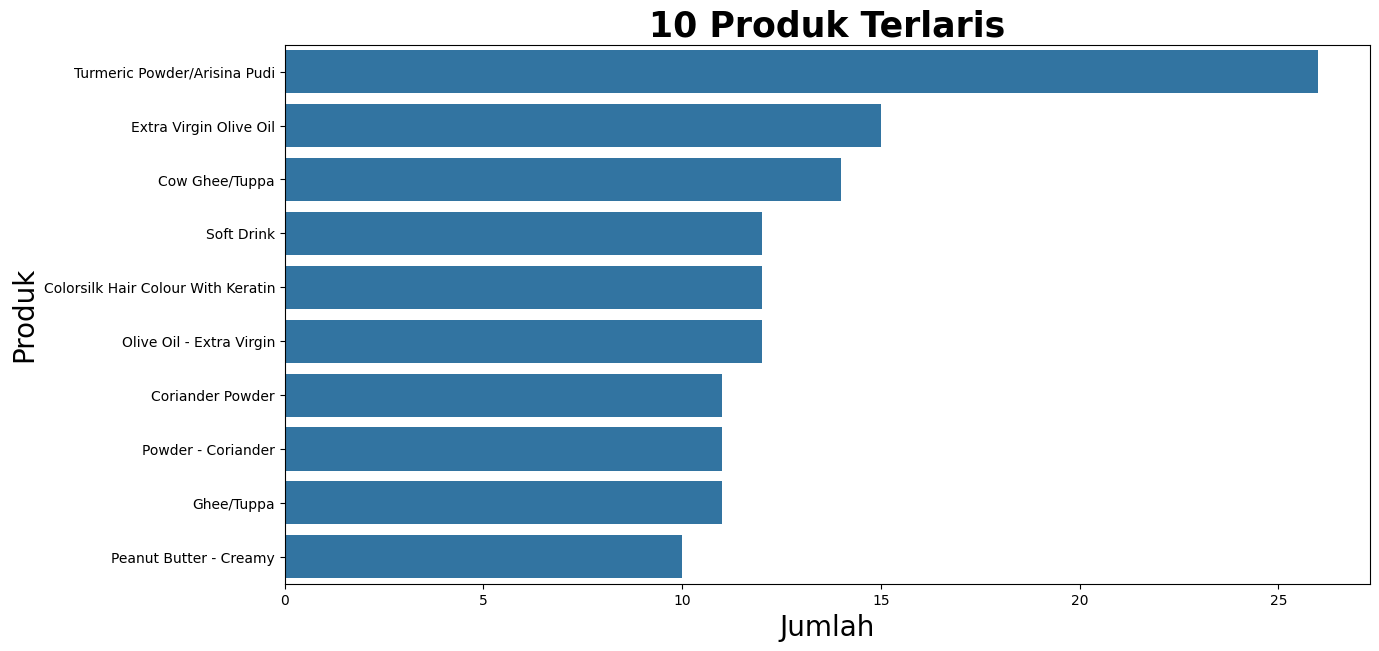

In [12]:
data = df['product'].value_counts()[:10]
plt.figure(figsize=(14,7))
sns.barplot(x=data,y=data.index)
plt.xlabel('Jumlah',fontdict={'fontsize': 20})
plt.ylabel('Produk',fontdict={'fontsize': 20})
plt.title('10 Produk Terlaris',fontweight="bold",fontdict={'fontsize': 25})
plt.rcParams['font.size'] = 10

**8. Daftar 10 produk yang paling sedikit terjual**

In [13]:
least_10 = pd.DataFrame(df[['product', 'category']].value_counts().tail(10)).reset_index()
least_10.columns = ['produk', 'kategori', 'jumlah']
least_10

,produk,kategori,jumlah
0,Geometry Box - Kidzz,Cleaning & Household,1
1,Geometry Box - Invento,Cleaning & Household,1
2,Geometry Box - Export,Cleaning & Household,1
3,"Geometry Box - Disney, Invento",Cleaning & Household,1
4,Geometry Box - Asteroid,Cleaning & Household,1
5,Geometry Box - Archimedes,Cleaning & Household,1
6,Genuine Wood Shaving Brush,Beauty & Hygiene,1
7,Gentleman Urbane Deodorant,Beauty & Hygiene,1
8,Gentleman Urbane - Eau De Parfum For Men,Beauty & Hygiene,1
9,pasta shell,Snacks & Branded Foods,1


**9. Produk unggulan (rating 5) berbasis kategori**

In [14]:
max_rating = df['rating'].max()
top_items = df.loc[df['rating'] == max_rating]
top_items

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
12,13,"Face Wash - Oil Control, Active",Beauty & Hygiene,Skin Care,Oxy,110.00,110.0,Face Care,5.0,This face wash deeply cleanses dirt and impuri...
16,17,Smooth Skin Oil - For Dry Skin,Beauty & Hygiene,Skin Care,Aroma Treasures,324.00,360.0,Aromatherapy,5.0,"Specially crafted for dry skin, this richly fo..."
24,25,Veggie Cutter,"Kitchen, Garden & Pets",Kitchen Accessories,IRICH,195.00,195.0,Choppers & Graters,5.0,"Food Grade High Quality Plastic, Keep and stor..."
44,45,Plain Green Olives,Gourmet & World Food,Tinned & Processed Food,Figaro,179.00,179.0,"Olive, Jalapeno, Gherkin",5.0,Olives are small fruits that grow on olive tre...
92,93,Topp Up Milk - Elaichi,"Bakery, Cakes & Dairy",Dairy,Gowardhan,80.01,90.0,"Flavoured, Soya Milk",5.0,Gowardhan Topp-Up Milk is made by 100 % of cow...
...,...,...,...,...,...,...,...,...,...,...
27507,27508,Extra Crisp Sweet Corn,Gourmet & World Food,Tinned & Processed Food,Daucy,202.50,225.0,Beans & Pulses,5.0,We bring for you Europe’s leading brand of can...
27508,27509,Palm Jaggery/Bella Crystals,"Foodgrains, Oil & Masala","Salt, Sugar & Jaggery",Draft,199.00,199.0,Sugar & Jaggery,5.0,It is a healthy alternative to white sugar and...
27512,27513,"Water Bottle - Fridge, Tulip, Dark Blue","Kitchen, Garden & Pets",Storage & Accessories,Cello,109.00,137.0,Water & Fridge Bottles,5.0,Cello Tulip fridge bottle is manufactured by J...
27515,27516,EDT Spray - Musk For Men,Beauty & Hygiene,Fragrances & Deos,Brut,595.00,595.0,Men's Deodorants,5.0,Brut Musk was launched in 1986 as an elegant m...


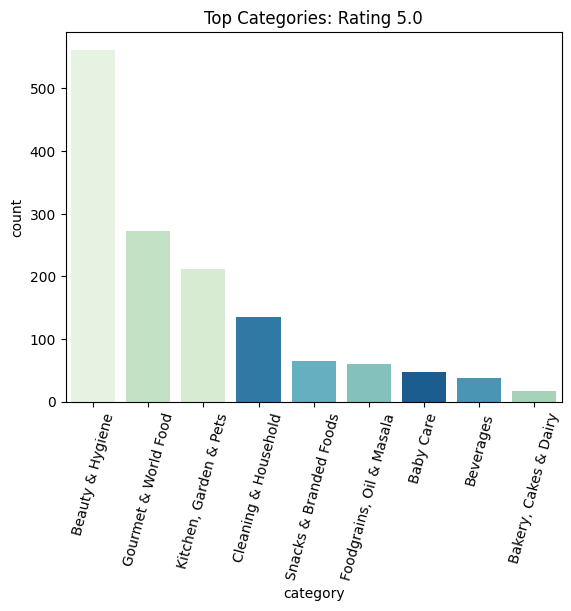

In [15]:
sns.countplot(x='category', data=top_items, hue='category', palette='GnBu', order = top_items['category'].value_counts().index)
plt.xticks(rotation=75)
plt.title('Top Categories: Rating 5.0')
plt.show()

**10. Produk dengan rating terendah "1" berbasis kategori**

In [16]:
min_rating = df['rating'].min()
bottom_items = df.loc[df['rating'] == min_rating]
bottom_items

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
64,65,Aqua Halo Rejuvenating Conditioner,Beauty & Hygiene,Hair Care,Azafran,168.75,225.0,Shampoo & Conditioner,1.0,This Aqua Halo Rejuvenating Conditioner is an ...
298,299,Family Sunscreen Lotion SPF 25,Beauty & Hygiene,Skin Care,INATUR,273.00,420.0,Face Care,1.0,Family Sunscreen SPF 25 is an innovative sun p...
299,300,Japanese Cooking Rice-Wine,Gourmet & World Food,Oils & Vinegar,Urban Platter,475.00,500.0,Flavoured & Other Oils,1.0,"Urban Platter Japanese Cooking Rice-Wine, 500m..."
435,436,Aloe Vera Juice - Purifies Blood & Boosts Immu...,Gourmet & World Food,Drinks & Beverages,Jiva Ayurveda,220.00,220.0,Health Drinks,1.0,"A natural anti-oxidant and blood purifier, Alo..."
451,452,Hair Serum - Anti-Dandruff,Beauty & Hygiene,Hair Care,Aroma Magic,637.50,750.0,Hair Oil & Serum,1.0,"I am 100% free of parabens, petrochemicals, su..."
...,...,...,...,...,...,...,...,...,...,...
27191,27192,Mukhallat Khas Concentrated Oriental Perfume F...,Beauty & Hygiene,Fragrances & Deos,Ajmal,1500.00,1500.0,Attar,1.0,A special oriental blend that will appeal to i...
27262,27263,PP Raspberry Belt,Gourmet & World Food,Chocolates & Biscuits,Kantan,30.00,30.0,"Marshmallow, Candy, Jelly",1.0,Fini Fantan Raspberry Belts contains raspberry...
27285,27286,"Dry Shampoo - Instant Hair Refresh, Coconut & ...",Beauty & Hygiene,Hair Care,Batiste,649.00,649.0,Dry Shampoo & Conditioner,1.0,"Batiste refreshes your hair between washes, le..."
27367,27368,Moroccan Argan Hair Growth Oil For Hair Growth...,Beauty & Hygiene,Hair Care,Khadi Meghdoot,375.00,375.0,Shampoo & Conditioner,1.0,This oil comes with the goodness of natural an...


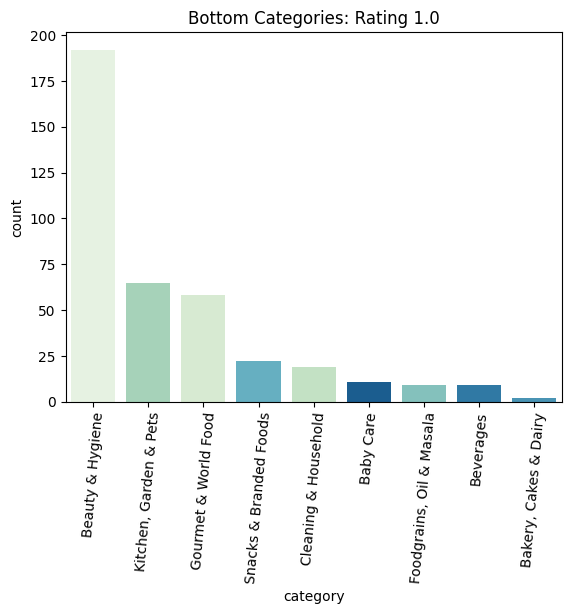

In [17]:
sns.countplot(x='category', data=bottom_items, hue='category', palette='GnBu', order = bottom_items['category'].value_counts().index)
plt.xticks(rotation=85)
plt.title('Bottom Categories: Rating 1.0')
plt.show()

##**Data Preparation**

**1. Dropping Uneeded Column**<br>
Kita akan menghapus kolom yang tidak relevan untuk analisis lebih lanjut.

In [18]:
df.drop('index', axis=1, inplace=True)
df.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


**2. Detection and Removal Duplicates**<br>
Sebelum membangun model, kita akan memeriksa duplikasi dalam data dan menghapusnya untuk memastikan data yang digunakan tidak redundan.

In [19]:
print(f"Total Duplicates : {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"After remove Duplicates : {df.duplicated().sum()}")

Total Duplicates : 354
After remove Duplicates : 0


**3. Handling Missing Value**<br>
Kita juga perlu menangani nilai yang hilang dalam data, baik dengan mengisi nilai yang hilang atau menghapus baris yang mengandung nilai yang hilang.

In [20]:
# sebelum perlakuan
df.isnull().sum()

,0
product,1
category,0
sub_category,0
brand,1
sale_price,0
market_price,0
type,0
rating,8463
description,113


<Axes: xlabel='rating', ylabel='Count'>

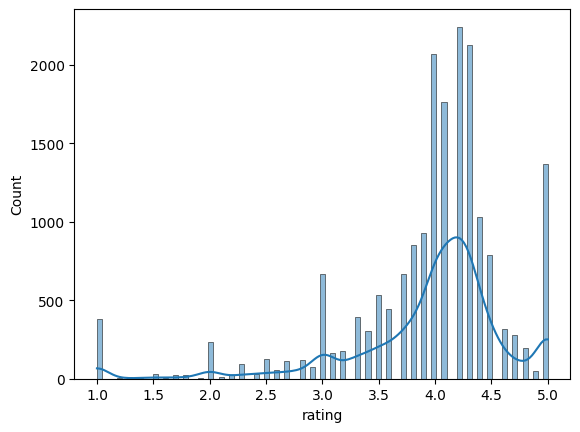

In [21]:
# Distribusi kolom rating
sns.histplot(df.rating,kde=True)

In [22]:
# Mean ratings
rating_mean = df.rating.mean()
rating_mean

3.9444337709467394

In [23]:
# Median ratings
rating_median = df.rating.median()
rating_median

4.1

In [24]:
# Nilai rating yang hilang, diisi dengan nilai mean rating
df['rating'] = df['rating'].fillna(value=rating_mean)

In [25]:
# Prosentase nilai yang hilang keseluruan
print('Total Data Null')
null_count = df.isnull().sum().sum()
total_count = np.product(df.shape)
print("{:.2f}".format(null_count/total_count * 100))

Total Data Null
0.05


In [26]:
# Menghapus nilai yang hilang
df.dropna()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.00,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.00,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.00,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.00,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.00,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...
...,...,...,...,...,...,...,...,...,...
27550,"Wottagirl! Perfume Spray - Heaven, Classic",Beauty & Hygiene,Fragrances & Deos,Layerr,199.20,249.0,Perfume,3.9,Layerr brings you Wottagirl Classic fragrant b...
27551,Rosemary,Gourmet & World Food,Cooking & Baking Needs,Puramate,67.50,75.0,"Herbs, Seasonings & Rubs",4.0,Puramate rosemary is enough to transform a dis...
27552,Peri-Peri Sweet Potato Chips,Gourmet & World Food,"Snacks, Dry Fruits, Nuts",FabBox,200.00,200.0,Nachos & Chips,3.8,We have taken the richness of Sweet Potatoes (...
27553,Green Tea - Pure Original,Beverages,Tea,Tetley,396.00,495.0,Tea Bags,4.2,"Tetley Green Tea with its refreshing pure, ori..."


In [27]:
# setelah perlakuan
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27201 entries, 0 to 27200
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product       27200 non-null  object 
 1   category      27201 non-null  object 
 2   sub_category  27201 non-null  object 
 3   brand         27200 non-null  object 
 4   sale_price    27201 non-null  float64
 5   market_price  27201 non-null  float64
 6   type          27201 non-null  object 
 7   rating        27201 non-null  float64
 8   description   27088 non-null  object 
dtypes: float64(3), object(6)
memory usage: 1.9+ MB


**4. Changing Certain Value** (menghapus &, memisahkan string, menyusun dalam bentuk list)

In [28]:
df2 = df.copy()

In [29]:
rmv_spc = lambda a:a.strip()
get_list = lambda a:list(map(rmv_spc,re.split('& |, |\*|\n', a)))

In [30]:
for col in ['category', 'sub_category', 'type']:
    df2[col] = df2[col].apply(get_list)

**5. Changing Certain Value** (merubah jadi huruf kecil, menghilangkan spasi)

In [31]:
def cleaner(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [32]:
for col in ['category', 'sub_category', 'type','brand']:
    df2[col] = df2[col].apply(cleaner)

**6. Content-Based Filtering** <br>
- Menggabungkan nilai kategori, sub kategori, tipe & brand

In [33]:
df_cbf = df2.copy()

In [34]:
def couple(x):
    return ' '.join(x['category']) + ' ' + ' '.join(x['sub_category']) + ' '+x['brand']+' ' +' '.join( x['type'])
df_cbf['gab'] = df_cbf.apply(couple, axis=1)

- Ekstraksi Fitur TF-IDF

In [35]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_cbf['gab'])
tfidf_matrix.shape

(27201, 3083)

**7. Collaborative Filtering**<br>
- Simulate user IDs

In [36]:
df2['userID'] = (df2.index % 500) + 1

In [37]:
df2

,product,category,sub_category,brand,sale_price,market_price,type,rating,description,userID
0,Garlic Oil - Vegetarian Capsule 500 mg,"[beauty, hygiene]",[haircare],srisriayurveda,220.00,220.0,"[hairoil, serum]",4.1,This Product contains Garlic Oil that is known...,1
1,Water Bottle - Orange,"[kitchen, garden, pets]","[storage, accessories]",mastercook,180.00,180.0,"[water, fridgebottles]",2.3,"Each product is microwave safe (without lid), ...",2
2,"Brass Angle Deep - Plain, No.2","[cleaning, household]",[poojaneeds],trm,119.00,250.0,"[lamp, lampoil]",3.4,"A perfect gift for all occasions, be it your m...",3
3,Cereal Flip Lid Container/Storage Jar - Assort...,"[cleaning, household]","[bins, bathroomware]",nakoda,149.00,176.0,"[laundry, storagebaskets]",3.7,Multipurpose container with an attractive desi...,4
4,Creme Soft Soap - For Hands & Body,"[beauty, hygiene]","[bath, handwash]",nivea,162.00,162.0,"[bathingbars, soaps]",4.4,Nivea Creme Soft Soap gives your skin the best...,5
...,...,...,...,...,...,...,...,...,...,...
27196,"Wottagirl! Perfume Spray - Heaven, Classic","[beauty, hygiene]","[fragrances, deos]",layerr,199.20,249.0,[perfume],3.9,Layerr brings you Wottagirl Classic fragrant b...,197
27197,Rosemary,"[gourmet, worldfood]","[cooking, bakingneeds]",puramate,67.50,75.0,"[herbs, seasonings, rubs]",4.0,Puramate rosemary is enough to transform a dis...,198
27198,Peri-Peri Sweet Potato Chips,"[gourmet, worldfood]","[snacks, dryfruits, nuts]",fabbox,200.00,200.0,"[nachos, chips]",3.8,We have taken the richness of Sweet Potatoes (...,199
27199,Green Tea - Pure Original,[beverages],[tea],tetley,396.00,495.0,[teabags],4.2,"Tetley Green Tea with its refreshing pure, ori...",200


- Encode Label<br>
Untuk menggunakan algoritma berbasis matriks, kita perlu mengonversi data kategorikal menjadi numerik.

In [38]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df2['userID'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [39]:
# Mengubah product menjadi list tanpa nilai yang sama
produk_ids = df2['product'].unique().tolist()

# Melakukan proses encoding product
produk_to_produk_encoded = {x: i for i, x in enumerate(produk_ids)}

# Melakukan proses encoding angka ke product
produk_encoded_to_produk = {i: x for i, x in enumerate(produk_ids)}

In [40]:
# Mapping userID ke dataframe user
df2['user'] = df2['userID'].map(user_to_user_encoded)

# Mapping product ke dataframe produk
df2['produk'] = df2['product'].map(produk_to_produk_encoded)

In [41]:
num_users = len(user_to_user_encoded) # Mendapatkan jumlah user
num_produk = len(produk_encoded_to_produk) # Mendapatkan jumlah produk
min_rating = min(df2['rating']) # Nilai minimum rating
max_rating = max(df2['rating']) # Nilai maksimal rating

print('jumlah user: {}'.format(num_users))
print('jumlah produk: {}'.format(num_produk))
print('Min rating: {}'.format(min_rating))
print('Max rating: {}'.format(max_rating))

jumlah user: 500
jumlah produk: 23541
Min rating: 1.0
Max rating: 5.0


**Train Test Split**<br>
Membagi data menjadi set pelatihan dan set pengujian untuk evaluasi model.

- Split Data

In [42]:
# Mengacak dataset
df2 = df2.sample(frac=1, random_state=42)
df2

,product,category,sub_category,brand,sale_price,market_price,type,rating,description,userID,user,produk
1512,Neem Tulsi Body Wash Soap,"[beauty, hygiene]","[bath, handwash]",meghdoot,70.00,70.0,"[bathingbars, soaps]",3.944434,The Meghdoot's Neem Tulsi Body Wash is an Ayur...,13,12,1498
13632,"Lunch Box - Stainless Steel, Midday Maxx Fresh...","[kitchen, garden, pets]",[steelutensils],signoraware,390.00,390.0,[steellunchboxes],4.300000,Midday Max Fresh Stainless Steel Lunch Box Set...,133,132,12544
9942,"Incense Sticks - Namo Stuti, Scented","[cleaning, household]",[poojaneeds],giri,100.00,100.0,"[agarbatti, incensesticks]",3.944434,Giri incense sticks are made using natural her...,443,442,9313
19969,Smart Matic Bluetooth Enabled Automatic Air Fr...,"[cleaning, household]","[fresheners, repellents]",godrejaer,703.12,799.0,[airfreshener],2.300000,Godrej Aer Smart Matic is India’s 1st mobile-c...,470,469,17804
10497,Maharaja Plastic Soap Case - Lily Garden Brown,"[cleaning, household]","[bins, bathroomware]",ratan,29.00,43.0,"[soapcases, dispensers]",4.100000,This premium soap case is made of high-quality...,498,497,9812
...,...,...,...,...,...,...,...,...,...,...,...,...
21575,Instant Pasta Sauce Mix - Pepper Alfredo,"[gourmet, worldfood]","[cooking, bakingneeds]",veekes&company,49.00,49.0,"[herbs, seasonings, rubs]",3.944434,Veekes and company bring to you a quick and af...,76,75,19095
5390,Secure XL Cottony Soft 2x20pcs+Dry-Max All Nig...,"[beauty, hygiene]",[femininehygiene],stayfree,279.83,320.0,[sanitarynapkins],3.944434,Extra Large napkin with cottony cover for long...,391,390,5176
860,PP Apple Belt,"[gourmet, worldfood]","[chocolates, biscuits]",kantan,30.00,30.0,"[marshmallow, candy, jelly]",5.000000,Fini Fantan Apple Belts contains green apple f...,361,360,850
15795,Diamond Whisky/Juice Glass Tumbler,"[kitchen, garden, pets]","[crockery, cutlery]",pasabahce,579.00,786.0,[glassware],3.000000,This is a brand that is an essential part of o...,296,295,14347


In [43]:
# Membuat variabel x untuk mencocokkan data user dan produk menjadi satu value
x = df2[['user', 'produk']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df2['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [44]:
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [45]:
print("panjang array dari x_train : " + str(len(x_train)))
x_train

print("panjang array dari x_val : " + str(len(x_val)))
x_val

panjang array dari x_train : 21760
panjang array dari x_val : 5441


array([[  388, 16100],
       [  306,  1783],
       [  371,  3764],
       ...,
       [  360,   850],
       [  295, 14347],
       [  154, 20753]])

In [46]:
print("panjang array dari y_train : " + str(len(y_train)))
y_train

print("panjang array dari y_val : " + str(len(y_val)))
y_val

panjang array dari y_train : 21760
panjang array dari y_val : 5441


array([0.75 , 0.575, 0.625, ..., 1.   , 0.5  , 0.45 ])

##**Modeling and Results**

**Content-Based Filtering** <br>
Menggunakan TF-IDF Vectorization dan Cosine Similarity untuk menghitung kesamaan antara produk berdasarkan atribut kategori, sub kategori, brand dan tipe produk.

In [47]:
tfidf_matrix

<27201x3083 sparse matrix of type '<class 'numpy.float64'>'
	with 178093 stored elements in Compressed Sparse Row format>

In [48]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05572012],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.05572012, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [49]:
cosine_sim.shape

(27201, 27201)

In [50]:
nama_produk = df_cbf['product']
produk_index = pd.Series(df_cbf.index, index=df_cbf['product'])

In [51]:
def product_recommendations(nama_produk, cosine_sim=cosine_sim):

    idx = produk_index[nama_produk]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    produk_index5 = [i[0] for i in sim_scores]
    return df_cbf['product'].iloc[produk_index5]

In [60]:
# Nama produk yang diminta user
nama_produk_test = np.random.choice(nama_produk)
nama_produk_test

'Dark Melody Coffee Beans Roasted'

In [61]:
# Hasil rekomendasi produk yang relevan
rekom = product_recommendations(nama_produk_test)
pd.DataFrame({'Produk diminta': nama_produk_test,'Rekomendasi produk relevan':rekom})

,Produk diminta,Rekomendasi produk relevan
10430,Dark Melody Coffee Beans Roasted,Morning Motivation Instant Coffee Powder Make ...
13850,Dark Melody Coffee Beans Roasted,Breakfast Fusion Coffee Beans Roasted
14514,Dark Melody Coffee Beans Roasted,Signature Filter Instant Coffee Powder Make Co...
15317,Dark Melody Coffee Beans Roasted,Dark Melody Coffee Beans Roasted
20927,Dark Melody Coffee Beans Roasted,Euphoria Instant Coffee Powder Make Cold Coffe...
4253,Dark Melody Coffee Beans Roasted,Green Coffee Powder
19621,Dark Melody Coffee Beans Roasted,Green Coffee Beans
21989,Dark Melody Coffee Beans Roasted,Green Coffee Powder
8021,Dark Melody Coffee Beans Roasted,Chicory Powder
11539,Dark Melody Coffee Beans Roasted,Green Coffee Beans - Unroasted Arabica


**Collaborative Filtering**<br>
Menggunakan class RecommenderNet untuk Collaborative Filtering.

In [62]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_produk, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_produk = num_produk
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.produk_embedding = layers.Embedding( # layer embeddings produk
        num_produk,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.produk_bias = layers.Embedding(num_produk, 1) # layer embedding produk bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    produk_vector = self.produk_embedding(inputs[:, 1]) # memanggil layer embedding 3
    produk_bias = self.produk_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_produk = tf.tensordot(user_vector, produk_vector, 2)

    x = dot_user_produk + user_bias + produk_bias

    return tf.nn.sigmoid(x) # activation sigmoid

**Inisialisasi model dan compile**

In [63]:
# inisialisasi model
model = RecommenderNet(num_users, num_produk, 50)

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

**Training terhadap model**

In [64]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_root_mean_squared_error',
                              patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [65]:
# Memulai training
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    callbacks = [early_stopper],
    validation_data = (x_val, y_val)
)

Epoch 1/100
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 64s 23ms/step - loss: 0.6792 - root_mean_squared_error: 0.2664 - val_loss: 0.6409 - val_root_mean_squared_error: 0.2306
Epoch 2/100
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 64s 16ms/step - loss: 0.5789 - root_mean_squared_error: 0.1529 - val_loss: 0.6371 - val_root_mean_squared_error: 0.2258
Epoch 3/100
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 83s 16ms/step - loss: 0.5769 - root_mean_squared_error: 0.1489 - val_loss: 0.6338 - val_root_mean_squared_error: 0.2220
Epoch 4/100
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - loss: 0.5747 - root_mean_squared_error: 0.1467 - val_loss: 0.6282 - val_root_mean_squared_error: 0.2156
Epoch 5/100
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - loss: 0.5755 - root_mean_squared_error: 0.1458 - val_loss: 0.6231 - val_root_mean_squared_error: 0.2097
Epoch 6/100
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 80s 17ms/step - loss: 0.5713 - root_mean_squared_error: 0.1435 - val_loss: 0.6184 - val_root_mean_squared_error: 0.2043
Epoch 7/100
2720/2720 

**Membuat variabel produk_not_rated sebagai daftar produk untuk direkomendasikan pada pengguna.**

In [78]:
#Mengambil sample user
user_id = df2.userID.sample(1).iloc[0]
produk_rated_by_user = df2[df2.userID == user_id]

produk_not_rated = df2[~df2['product'].isin(produk_rated_by_user.produk.values)]['product']
produk_not_rated = list(
    set(produk_not_rated)
    .intersection(set(produk_to_produk_encoded.keys()))
)

produk_not_rated = [[produk_to_produk_encoded.get(x)] for x in produk_not_rated]
user_encoder = user_to_user_encoded.get(user_id)
user_produk_array = np.hstack(
    ([[user_encoder]] * len(produk_not_rated), produk_not_rated)
)

**Hasil rekomendasi produk**

In [79]:
ratings = model.predict(user_produk_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_produk_ids = [
    produk_encoded_to_produk.get(produk_not_rated[x][0]) for x in top_ratings_indices
]

print('Daftar recommendations produk untuk users: {}'.format(user_id))
print('===' * 9)
print('produk dengan rating tinggi dari user')
print('----' * 8)

top_produk_user = (
    produk_rated_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    ['product'].values
)

df2_rows = df2[df2['product'].isin(top_produk_user)]
for row in df2_rows.itertuples():
    print(row.product, ':', row.brand)

print('----' * 8)
print('Top 10 produk recommendation')
print('----' * 8)

recommended_produk = df2[df2['product'].isin(recommended_produk_ids)].drop_duplicates(subset='product')
for row in recommended_produk.itertuples():
    print(row.product, ':', row.brand)

736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Daftar recommendations produk untuk users: 389
produk dengan rating tinggi dari user
--------------------------------
Blue Set - Eau De Toilette + Deodorant : ulricdevarens
Dharwad Peda : sangamsweets
Green Tea Skin Clarifying Concentrate : plum
Rapid Reviver 6 Oil Nourish Deep Conditioner : lorealparis
Passion Femme Eau De Toilette : police
--------------------------------
Top 10 produk recommendation
--------------------------------
Combo - Precision Safety Razor & 10 Feather Blades : bombayshavingcompany
Steel Lid See Through, Square Jars : yera
Easy Adult Diaper - Large : friends
Taft Power Wax : schwarzkopf
Wonder Diaper Pants - Large Size : huggies
Ultimate Choco Berry : ritebitemaxprotein
Charcoal Bath Soap : bombayshavingcompany
Tapioca Flour - Sabudana : nuttyyogi
Body Deodorant - Ultra Sensual : wildstone
Water & Juice Glass - Long : krosno-europe


##**Evaluation**<br>
Untuk mengevaluasi kedua model rekomendasi ini, kita dapat menggunakan precision dan recall untuk mengukur akurasi prediksi.

###**Content Based Filtering**

In [97]:
def evaluate_precision(nama_produk_test, rekom, df_cbf):
    """
    Fungsi untuk mengevaluasi precision rekomendasi.

    Parameters:
        nama_produk_test (str): Produk yang diminta.
        rekom (list): Produk rekomendasi yang dihasilkan.
        df_cbf (pd.DataFrame): DataFrame dengan informasi relevansi.

    Returns:
        float: Nilai precision untuk produk yang diuji.
    """

    # Mendapatkan relevansi produk rekomendasi
    df_cbf['relevant'] = df_cbf['product'].isin(rekom).astype(int)

    # Filter df_cbf untuk hanya menyertakan produk yang direkomendasikan
    relevant_products_df = df_cbf[df_cbf['product'].isin(rekom)]

    # Nilai target sebenarnya (relevansi) untuk produk yang direkomendasikan
    y_true = relevant_products_df['relevant'].values
    y_pred = [1] * len(y_true)

    # Hitung precision (menangani zero division jika diperlukan)
    precision = precision_score(y_true, y_pred, zero_division=0)
    return precision

# Evaluasi model menggunakan precision
precision_value = evaluate_precision(nama_produk_test, rekom, df_cbf)
print(f"Precision untuk produk '{nama_produk_test}': {precision_value:.2f}")

Precision untuk produk 'Dark Melody Coffee Beans Roasted': 1.00


###**Collaborative Filtering**

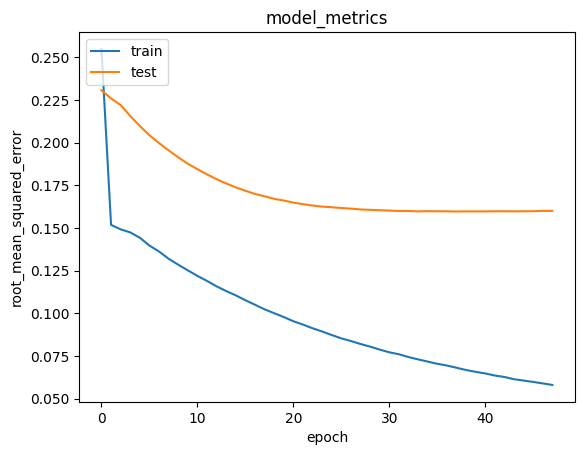

In [82]:
# Menampilkan grafik traning vs test
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###**References**

# Ali Saifudin (drh_ali)

ali.saifudin.385758-2022@fkh.unair.ac.id

Kabupaten Blora
"""